# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

## Imports

In [17]:
import os
import sys
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../') 

## Definitions

In [18]:
from utils import get_constants

constants = get_constants()

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

In [19]:
eng_formatter = mpl.ticker.EngFormatter(places=1, sep='')


def full_eng_formatter(value, total):
    return f"{eng_formatter(value)} ({value / total:.1%})"

In [20]:
df = pd.read_parquet(parquet_path)
refined_df = pd.read_parquet(refined_parquet_path)

# Model

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

feature_list = [col for col in df.columns if col not in {'label', 'general_label'}]
refined_feature_list = [col for col in refined_df.columns if col not in {'label', 'general_label'}]

# Baseline

https://www.mdpi.com/2079-9292/13/6/1053

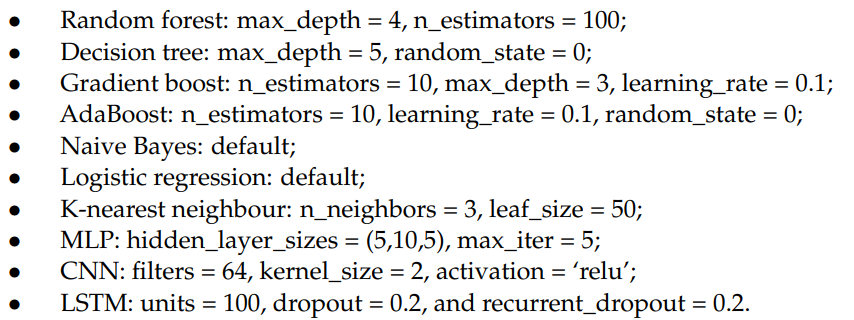

In [32]:
def run_with_time(f, title):
    t0 = datetime.datetime.now()
    res = f()
    t1 = datetime.datetime.now()
    print(f"Execution time ({title}): {t1 - t0}")

    return res


def test_model(df, features, model, target='general_label', train_frac=0.05):
    X_train, X_test, y_train, y_test = train_test_split(
        df[features],
        df['general_label'],
        test_size=(1 - train_frac),
        random_state=42
    )

    print(f"Trainning dataset size: {full_eng_formatter(len(X_train), len(df))}.")

    # run_with_time(lambda: model.fit(X_train, y_train), title="Model fit")
    # y_pred = run_with_time(lambda: model.predict(X_test), title="Predict")

    return model

In [33]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier())
])

test_model(df, feature_list, model, train_frac=0.03)

Trainning dataset size: 1.4M (3.0%).


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', RandomForestClassifier())])

In [28]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier())
])

test_model(df, features, model)

Execution time (Model fit): 0:02:57.942195
Execution time (Predict): 0:00:04.255603


Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', RandomForestClassifier())])

In [5]:
%%time

df_sample = df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)
y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

              precision    recall  f1-score   support

      Benign       0.73      0.90      0.81      7092
  BruteForce       1.00      0.13      0.23        83
        DDoS       0.83      0.99      0.90    218562
         DoS       0.77      0.15      0.24     51958
       Mirai       0.99      0.99      0.99     16808
       Recon       0.60      0.42      0.49      2191
    Spoofing       0.77      0.48      0.59      3131
         Web       0.00      0.00      0.00       175

    accuracy                           0.83    300000
   macro avg       0.71      0.51      0.53    300000
weighted avg       0.82      0.83      0.78    300000



NameError: name 'plt' is not defined

In [6]:
%%time

df_sample = refined_df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[refined_features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df[features]
# y_train = df['general_label']

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LogisticRegression(max_iter=200, tol=1e-3))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

fig, ax = plt.subplots(figsize=(9, 5))
cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=df.general_label.cat.categories)
fig.tight_layout()
cmp.plot(ax=ax)

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.73      0.90      0.81      7076
  BruteForce       1.00      0.14      0.25        97
        DDoS       0.83      0.99      0.90    217897
         DoS       0.77      0.15      0.25     52345
       Mirai       0.99      0.99      0.99     17009
       Recon       0.64      0.41      0.50      2241
    Spoofing       0.73      0.47      0.57      3165
         Web       0.00      0.00      0.00       170

    accuracy                           0.83    300000
   macro avg       0.71      0.51      0.53    300000
weighted avg       0.82      0.83      0.78    300000



/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


NameError: name 'plt' is not defined

In [19]:
%%time

df_sample = df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_1[features]
# y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.68      0.99      0.81      6897
  BruteForce       0.00      0.00      0.00        77
        DDoS       1.00      1.00      1.00    218266
         DoS       1.00      1.00      1.00     52178
       Mirai       1.00      0.99      1.00     16986
       Recon       0.98      0.29      0.45      2257
    Spoofing       0.89      0.56      0.69      3174
         Web       0.00      0.00      0.00       165

    accuracy                           0.99    300000
   macro avg       0.69      0.60      0.62    300000
weighted avg       0.99      0.99      0.99    300000

CPU times: user 2min 33s, sys: 1.51 s, total: 2min 35s
Wall time: 2min 35s


/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
%%time

df_sample = refined_df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[refined_features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_1[features]
# y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.72      0.99      0.83      6924
  BruteForce       0.00      0.00      0.00        90
        DDoS       1.00      1.00      1.00    218750
         DoS       1.00      1.00      1.00     51861
       Mirai       1.00      0.99      1.00     16904
       Recon       0.98      0.37      0.54      2198
    Spoofing       0.87      0.63      0.73      3107
         Web       0.00      0.00      0.00       166

    accuracy                           0.99    300000
   macro avg       0.70      0.62      0.64    300000
weighted avg       0.99      0.99      0.99    300000

CPU times: user 2min 44s, sys: 1.48 s, total: 2min 46s
Wall time: 2min 46s


/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
%%time

class_1 = {'DDoS', 'DoS', 'Mirai'}
df_sample = df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'].where(df_sample.general_label.isin(class_1), 'Benign'), test_size=0.2, random_state=42)

# X_train = X_test = df_class_1[features]
# y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LogisticRegression(max_iter=200, tol=1e-3))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Benign       0.93      0.93      0.93     12502
        DDoS       0.83      0.99      0.90    218845
         DoS       0.77      0.14      0.24     51738
       Mirai       0.99      0.99      0.99     16915

    accuracy                           0.84    300000
   macro avg       0.88      0.76      0.77    300000
weighted avg       0.83      0.84      0.79    300000

CPU times: user 2min 38s, sys: 2min 7s, total: 4min 46s
Wall time: 1min 2s


In [64]:
%%time

class_1 = {'DDoS', 'DoS', 'Mirai'}
df_sample = df.loc[~df.general_label.isin(class_1)].sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_2[features]
# y_train = df_class_2['general_label']

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', LogisticRegression(max_iter=200, tol=1e-3))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Benign       0.75      0.94      0.84    166772
  BruteForce       0.99      0.14      0.24      1945
       Recon       0.74      0.55      0.63     53404
    Spoofing       0.80      0.56      0.66     74099
         Web       0.51      0.00      0.01      3780

    accuracy                           0.76    300000
   macro avg       0.76      0.44      0.48    300000
weighted avg       0.76      0.76      0.74    300000

CPU times: user 2min 53s, sys: 2min 19s, total: 5min 13s
Wall time: 1min 6s


## More complex

In [65]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
%%time

df_sample = df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_1[features]
# y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.72      0.99      0.83      7093
  BruteForce       0.00      0.00      0.00        62
        DDoS       1.00      1.00      1.00    218335
         DoS       1.00      1.00      1.00     52043
       Mirai       1.00      0.99      1.00     16819
       Recon       0.96      0.37      0.53      2374
    Spoofing       0.86      0.63      0.73      3119
         Web       0.00      0.00      0.00       155

    accuracy                           0.99    300000
   macro avg       0.69      0.62      0.64    300000
weighted avg       0.99      0.99      0.99    300000

CPU times: user 3min 55s, sys: 2.14 s, total: 3min 57s
Wall time: 3min 57s


/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [67]:
%%time

class_1 = {'DDoS', 'DoS', 'Mirai'}
df_sample = df.sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'].where(df_sample.general_label.isin(class_1), 'Benign'), test_size=0.2, random_state=42)

# X_train = X_test = df_class_1[features]
# y_train = df_class_1.general_label.where(df_class_1.general_label.isin(class_1), 'Benign')

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98     12792
        DDoS       1.00      1.00      1.00    218550
         DoS       1.00      1.00      1.00     51764
       Mirai       1.00      0.99      1.00     16894

    accuracy                           1.00    300000
   macro avg       0.99      1.00      0.99    300000
weighted avg       1.00      1.00      1.00    300000

CPU times: user 4min 7s, sys: 1.99 s, total: 4min 9s
Wall time: 4min 9s


In [90]:
for col, importance in sorted(zip(X_train.columns, model['svc'].feature_importances_), key=op.itemgetter(1), reverse=True):
    print(f"{col}: {importance:.2%}")

IAT: 38.79%
Min: 8.59%
Magnitue: 6.12%
flow_duration: 5.11%
AVG: 5.10%
Tot size: 4.58%
Header_Length: 4.00%
Max: 3.22%
Tot sum: 2.90%
rst_count: 2.82%
urg_count: 2.32%
Variance: 1.89%
Number: 1.79%
Covariance: 1.53%
Weight: 1.46%
Radius: 1.32%
Std: 1.12%
Srate: 1.06%
Rate: 1.04%
UDP: 0.94%
TCP: 0.64%
ICMP: 0.61%
ack_flag_number: 0.61%
Duration: 0.49%
HTTPS: 0.39%
syn_count: 0.35%
psh_flag_number: 0.26%
ack_count: 0.23%
rst_flag_number: 0.22%
fin_flag_number: 0.18%
fin_count: 0.18%
syn_flag_number: 0.11%
HTTP: 0.03%
LLC: 0.00%
DNS: 0.00%
Telnet: 0.00%
SMTP: 0.00%
SSH: 0.00%
IRC: 0.00%
DHCP: 0.00%
IPv: 0.00%
ARP: 0.00%
ece_flag_number: 0.00%
cwr_flag_number: 0.00%
Drate: 0.00%


In [92]:
%%time

class_1 = {'DDoS', 'DoS', 'Mirai'}
df_sample = df.loc[~df.general_label.isin(class_1)].sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_2[features]
# y_train = df_class_2['general_label']

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=6))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

      Benign       0.80      0.99      0.88    166572
  BruteForce       0.00      0.00      0.00      1961
       Recon       0.91      0.56      0.69     53957
    Spoofing       0.89      0.75      0.82     73804
         Web       0.00      0.00      0.00      3706

    accuracy                           0.83    300000
   macro avg       0.52      0.46      0.48    300000
weighted avg       0.83      0.83      0.82    300000

CPU times: user 6min 41s, sys: 1.98 s, total: 6min 43s
Wall time: 6min 43s


/var/fasttmp/bruno_dsn/conda_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
%%time

class_1 = {'DDoS', 'DoS', 'Mirai'}
df_sample = df.loc[~df.general_label.isin(class_1)].sample(1_500_000)

X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample['general_label'], test_size=0.2, random_state=42)

# X_train = X_test = df_class_2[features]
# y_train = df_class_2['general_label']

model = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', RandomForestClassifier(max_depth=8))
])

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Benign       0.84      0.98      0.90    166630
  BruteForce       1.00      0.00      0.01      2001
       Recon       0.88      0.68      0.77     53792
    Spoofing       0.90      0.77      0.83     73766
         Web       1.00      0.02      0.04      3811

    accuracy                           0.86    300000
   macro avg       0.92      0.49      0.51    300000
weighted avg       0.86      0.86      0.84    300000

CPU times: user 8min 16s, sys: 2.05 s, total: 8min 18s
Wall time: 8min 18s
